## Project 2 - Ames Housing Data and Kaggle Challenge

## Table of Contents

- [Load the Data](#Load-the-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Features Engineering](#Features-Engineering)
- [Load the Test Data](#Load-the-Test-Data)
- [Modelling](#Modelling)
 - [Baseline Model](#Baseline-Model)
 - [Linear Regression](#Linear-Regression)
 - [Ridge Regression](#Ridge-Regression)
 - [Lasso Regression](#Lasso-Regression)
 - [ElasticNet](#ElasticNet)
- [Generate model prediction for testset](#Generate-model-prediction-for-testset)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)



In [1]:
#Import basic packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Import model validation and preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE

#Import regression, metric, and regularization packages
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

#Set viewing max to 300 variables
pd.set_option('max_columns',300)
pd.set_option('max_rows', 200)



### Load the Data

In [2]:
#Read in the cleaned train data
train_clean = pd.read_csv('../datasets/train_clean.csv')

In [3]:
train_clean

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0      109  533352170           60        RL       69.0552     13517   Pave   
1      544  531379050           60        RL       43.0000     11492   Pave   
2      153  535304180           20        RL       68.0000      7922   Pave   
3      318  916386060           60        RL       73.0000      9802   Pave   
4      255  906425045           50        RL       82.0000     14235   Pave   
...    ...        ...          ...       ...           ...       ...    ...   
2046  1587  921126030           20        RL       79.0000     11449   Pave   
2047   785  905377130           30        RL       69.0552     12342   Pave   
2048   916  909253010           50        RL       57.0000      7558   Pave   
2049   639  535179160           20        RL       80.0000     10400   Pave   
2050    10  527162130           60        RL       60.0000      7500   Pave   

     alley  lot_shape land_contour  utilities lot_config  land_slope  \
0       Na          1          Lvl          3    CulDSac           2   
1       Na          1          Lvl          3    CulDSac           2   
2       Na          0          Lvl          3     Inside           2   
3       Na          0          Lvl          3     Inside           2   
4       Na          1          Lvl          3     Inside           2   
...    ...        ...          ...        ...        ...         ...   
2046    Na          1          HLS          3     Inside           2   
2047    Na          1          Lvl          3     Inside           2   
2048    Na          0          Bnk          3     Inside           2   
2049    Na          0          Lvl          3     Corner           2   
2050    Na          0          Lvl          3     Inside           2   

     neighborhood condition_1 condition_2 bldg_type house_style  overall_qual  \
0          Sawyer        RRAe        Norm      1Fam      2Story             6   
1         SawyerW        Norm        Norm      1Fam      2Story             7   
2           NAmes        Norm        Norm      1Fam      1Story             5   
3          Timber        Norm        Norm      1Fam      2Story             5   
4         SawyerW        Norm        Norm      1Fam      1.5Fin             6   
...           ...         ...         ...       ...         ...           ...   
2046       Timber        Norm        Norm      1Fam      1Story             8   
2047      Edwards        Norm        Norm      1Fam      1Story             4   
2048      Crawfor        Norm        Norm      1Fam      1.5Fin             6   
2049        NAmes        Norm        Norm      1Fam      1Story             4   
2050      Gilbert        Norm        Norm      1Fam      2Story             7   

      overall_cond  year_built  year_remod/add roof_style roof_matl  \
0                8        1976            2005      Gable   CompShg   
1                5        1996            1997      Gable   CompShg   
2                7        1953            2007      Gable   CompShg   
3                5        2006            2007      Gable   CompShg   
4                8        1900            1993      Gable   CompShg   
...            ...         ...             ...        ...       ...   
2046             5        2007            2007      Gable   CompShg   
2047             5        1940            1950      Gable   CompShg   
2048             6        1928            1950      Gable   CompShg   
2049             5        1956            1956      Gable   CompShg   
2050             5        1999            1999      Gable   CompShg   

     exterior_1st exterior_2nd mas_vnr_type  mas_vnr_area  exter_qual  \
0         HdBoard      Plywood      BrkFace           289           4   
1         VinylSd      VinylSd      BrkFace           132           4   
2         VinylSd      VinylSd         None             0           3   
3         VinylSd      VinylSd         None             0           3   
4  

#### Related Columns

In [4]:
#Assert if the total basement area is made up of the 3 categories of basement square foot provided
#This will help in dropping any multicollinear columns
assert (
    train_clean["total_bsmt_sf"]
    == (train_clean["bsmtfin_sf_1"] + train_clean["bsmtfin_sf_2"] + train_clean["bsmt_unf_sf"])).any()

In [5]:
#Assert if the ground living area is made up of the different floor space. 
#This will help to identify any multicollinear columns
assert (
    train_clean["gr_liv_area"]
    == (train_clean["1st_flr_sf"] + train_clean["2nd_flr_sf"] + train_clean["low_qual_fin_sf"])).any()

In [6]:
#Create an additional column to account for total square foot which is missing in the data provided
train_clean["total_sf"] = train_clean["gr_liv_area"] + train_clean['total_bsmt_sf']

In [7]:
#Create an additional column to account for the porch spaces
train_clean["total_porch_sf"] = train_clean["3ssn_porch"] + train_clean["enclosed_porch"] + train_clean["open_porch_sf"] + train_clean["screen_porch"] + train_clean["wood_deck_sf"]

In [8]:
#Create an additional column to account for the bathrooms
train_clean["total_bath"] = train_clean["full_bath"] + 0.5*train_clean["half_bath"] + train_clean["bsmt_full_bath"] + 0.5*train_clean["bsmt_half_bath"]

In [9]:
train_clean.shape

(2051, 84)

To better identify the different EDA that has to be performed on all the variables, e.g. Pearson only works with numerical values, the variables have been categorised into different data category to ensure all variables are covered. 

In [10]:
#Categorizing the columns into respective types for different correlation purposes + saleprice
train_nominal = train_clean[['ms_subclass', 
                            'ms_zoning', 
                            'street', 
                            'alley', 
                            'land_contour',
                            'lot_config',
                            'neighborhood',
                            'condition_1',
                            'condition_2',
                            'bldg_type',
                            'house_style',
                            'roof_style',
                            'roof_matl',
                            'exterior_1st', 
                            'exterior_2nd', 
                            'mas_vnr_type',
                            'foundation',
                            'heating',
                            'central_air',
                            'sale_type',
                            'garage_type',
                            'misc_feature',
                            'saleprice']]

In [11]:
train_continuous = train_clean[['lot_frontage',
                               'lot_area',
                               'bsmtfin_sf_1',
                               'bsmtfin_sf_2',
                               'bsmt_unf_sf',
                               'total_bsmt_sf',
                               '1st_flr_sf',
                               '2nd_flr_sf',
                               'low_qual_fin_sf',
                               'gr_liv_area',
                                'garage_area',
                               'wood_deck_sf',
                               'open_porch_sf',
                               'enclosed_porch',
                               '3ssn_porch',
                               'screen_porch',
                               'pool_area',
                               'misc_val',
                               'mas_vnr_area',
                                'total_sf',
                                'total_porch_sf',
                               'saleprice']]

In [12]:
train_discrete = train_clean[['year_built',
                             'year_remod/add',
                             'bsmt_full_bath',
                             'bsmt_half_bath',
                             'full_bath',
                             'half_bath',
                             'bedroom_abvgr',
                             'kitchen_abvgr',
                             'totrms_abvgrd',
                             'fireplaces',
                             'yr_sold',
                              'mo_sold',
                              'garage_cars',
                              'garage_yr_blt',
                              'total_bath',
                             'saleprice']]

In [13]:
train_ordinal = train_clean[['lot_shape',
                            'overall_qual',
                            'overall_cond',
                            'exter_qual',
                            'exter_cond',
                            'bsmt_qual',
                            'bsmt_cond',
                            'bsmt_exposure',
                            'bsmtfin_type_1',
                            'bsmtfin_type_2',
                            'heating_qc',
                            'functional',
                            'fireplace_qu',
                            'garage_finish',
                            'garage_qual',
                            'garage_cond',
                            'paved_drive',
                            'fence',
                            'kitchen_qual',
                            'pool_qc',
                            'utilities',
                            'electrical',
                            'land_slope',
                            'saleprice']]

### Exploratory Data Analysis

Pearson's correlation coefficient shows a linear relationship between two variables and works only on numerical categories. By running Pearson's correlation, we can easily identify the variables with high correlation with the saleprice

In [14]:
def plt_correlation(data, title):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(title, fontsize=24)
    labels = data.columns
     # Set up mask to be "True" in the upper triangle.
    mask = np.zeros_like(data,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_yticklabels(labels, fontsize=15)
    cmap = sns.diverging_palette(240, 0, as_cmap=True)
    sns.heatmap(
        data, vmin=-1, vmax=1, center=0, linewidths=.5,annot=True)
   

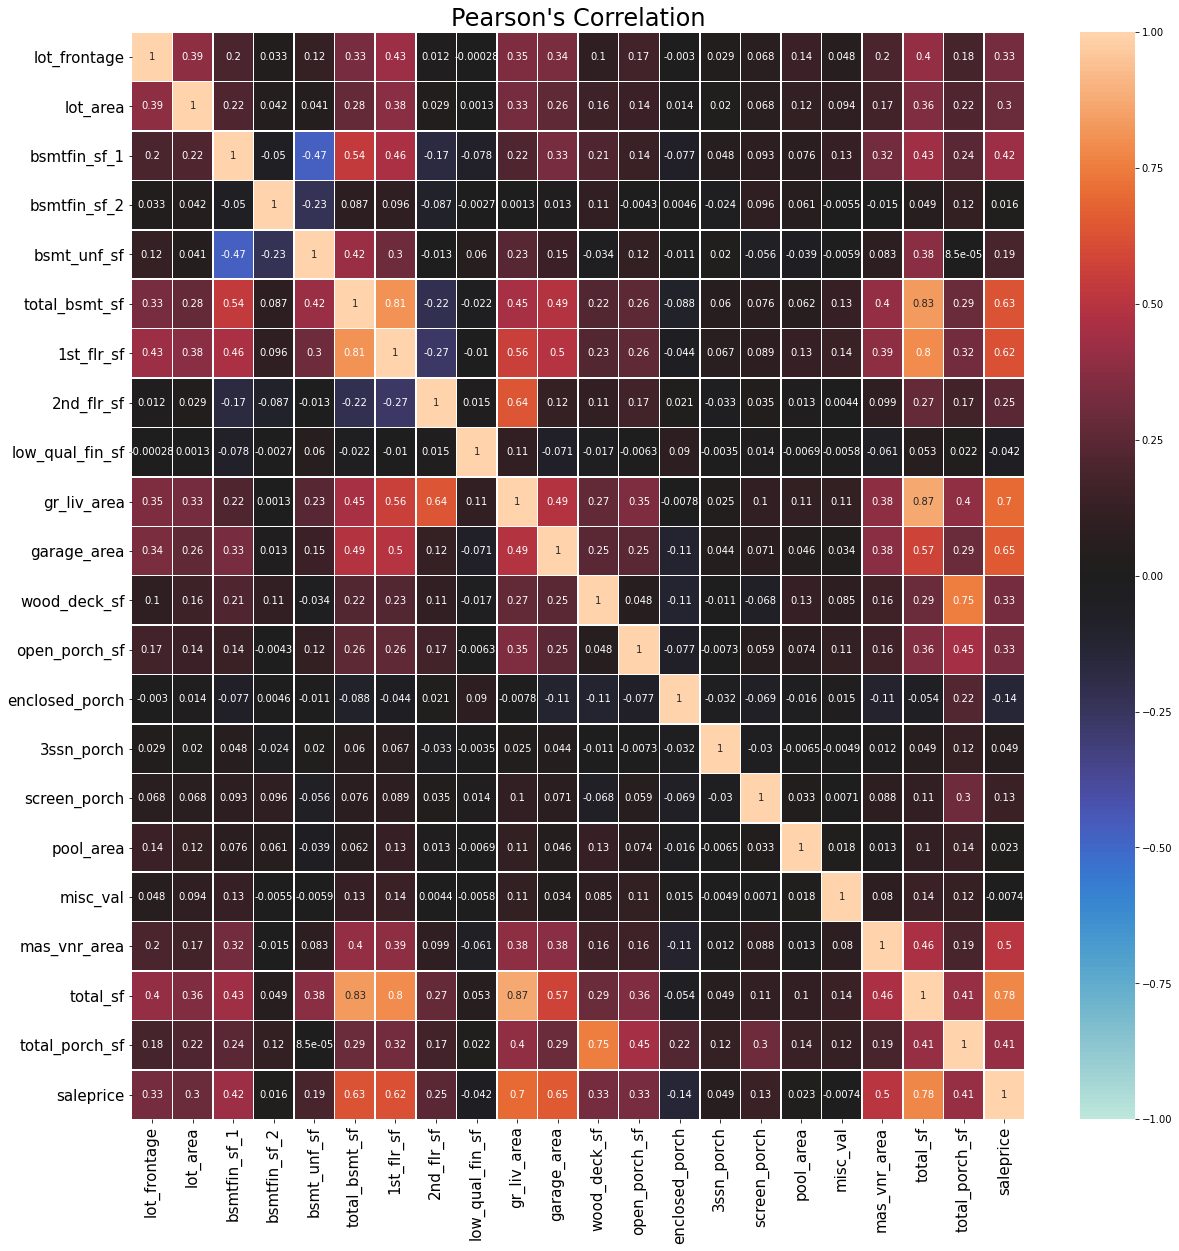

In [15]:
#Plot the Pearsons Correlation heatmap to see the relationship against saleprice
columns = train_continuous.columns
pearson = train_continuous[columns].corr(method="pearson")
plt_correlation(pearson, "Pearson's Correlation")

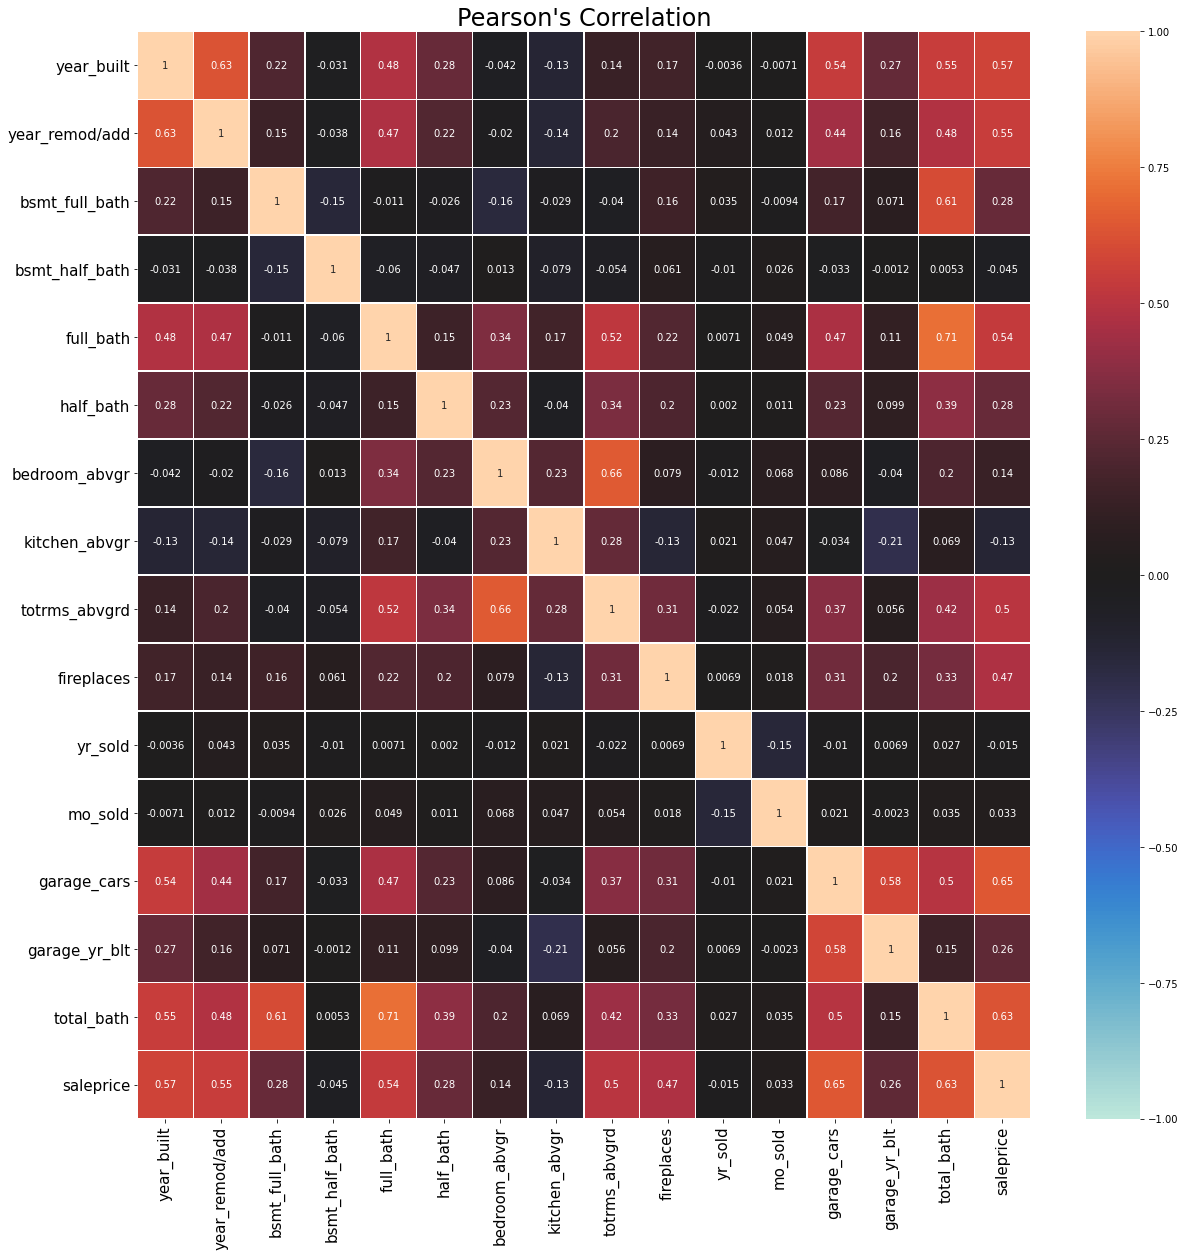

In [16]:
#Plot the Pearsons Correlation heatmap to see the relationship against saleprice
columns = train_discrete.columns
pearson = train_discrete[columns].corr(method="pearson")
plt_correlation(pearson, "Pearson's Correlation")

In [17]:
#For easy reference on the correlation values
train_discrete.corr('pearson')['saleprice'].sort_values(ascending=False)

saleprice         1.000000
garage_cars       0.648197
total_bath        0.630207
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
totrms_abvgrd     0.504014
fireplaces        0.471093
bsmt_full_bath    0.283332
half_bath         0.283001
garage_yr_blt     0.258645
bedroom_abvgr     0.137067
mo_sold           0.032735
yr_sold          -0.015203
bsmt_half_bath   -0.045290
kitchen_abvgr    -0.125444
Name: saleprice, dtype: float64

In [18]:
#For easy reference on the correlation values
train_continuous.corr('pearson')['saleprice'].sort_values(ascending=False)

saleprice          1.000000
total_sf           0.779286
gr_liv_area        0.697038
garage_area        0.650246
total_bsmt_sf      0.628668
1st_flr_sf         0.618486
mas_vnr_area       0.503579
bsmtfin_sf_1       0.423445
total_porch_sf     0.406338
open_porch_sf      0.333476
wood_deck_sf       0.326490
lot_frontage       0.325850
lot_area           0.296566
2nd_flr_sf         0.248452
bsmt_unf_sf        0.190262
screen_porch       0.134581
3ssn_porch         0.048732
pool_area          0.023106
bsmtfin_sf_2       0.016432
misc_val          -0.007375
low_qual_fin_sf   -0.041594
enclosed_porch    -0.135656
Name: saleprice, dtype: float64

In [19]:
#Specifically using Spearman correlation which works better on ordinal categories
train_ordinal.corr('spearman')['saleprice'].sort_values(ascending=False)

saleprice         1.000000
overall_qual      0.806923
bsmt_qual         0.698305
exter_qual        0.696716
kitchen_qual      0.684480
garage_finish     0.634720
fireplace_qu      0.543203
heating_qc        0.518756
bsmtfin_type_1    0.414060
bsmt_exposure     0.383902
garage_qual       0.368127
lot_shape         0.362025
paved_drive       0.350041
garage_cond       0.340525
electrical        0.309431
bsmt_cond         0.279943
functional        0.129437
bsmtfin_type_2    0.041645
utilities         0.036573
pool_qc           0.034903
exter_cond        0.030147
land_slope       -0.054132
overall_cond     -0.160501
Name: saleprice, dtype: float64

With the graphs and correlations above, there are many variables which are highly correlated with sales price but also highly correlated with each other. Therefore based on the ranking of the correlations is insufficient to determine which variables to be dropped. 

Below, the correlations above 0.6 are tabulated to better identify the features which are correlated in order to decide which to drop

In [20]:
corr = train_clean.corr()
high_corr = corr[corr.abs() > 0.6][corr.abs() != 1].unstack().dropna().to_dict()
high_corr = pd.Series(high_corr, index = high_corr.keys())
high_corr = high_corr.reset_index()
high_corr = pd.DataFrame(high_corr)
high_corr.columns = ['feature_1', 'feature_2','correlation']
high_corr['correlation'] = high_corr['correlation'].drop_duplicates(keep ='first')
high_corr = high_corr.dropna().sort_values(by = 'correlation', ascending = False)

In [21]:
high_corr.head(20)

feature_1       feature_2  correlation
58   garage_yr_blt     garage_cond     0.954885
64     garage_qual     garage_cond     0.950493
57   garage_yr_blt     garage_qual     0.947619
68       pool_area         pool_qc     0.904689
59     garage_cars     garage_area     0.893180
41     gr_liv_area        total_sf     0.869277
55      fireplaces    fireplace_qu     0.859734
31   total_bsmt_sf        total_sf     0.834771
39     gr_liv_area   totrms_abvgrd     0.813333
29   total_bsmt_sf      1st_flr_sf     0.808665
5     overall_qual       saleprice     0.800207
34      1st_flr_sf        total_sf     0.795967
80       saleprice        total_sf     0.779286
27  bsmtfin_type_2    bsmtfin_sf_2     0.777778
67    wood_deck_sf  total_porch_sf     0.754074
2     overall_qual      exter_qual     0.740257
17      exter_qual    kitchen_qual     0.730562
18      exter_qual       saleprice     0.712146
45       full_bath      total_bath     0.711336
24  bsmtfin_type_1    bsmtfin_sf_1     0.698885

From the table above, there are numerous garage features which are highly correlated with each other but pertaining to the same feature of the house. Therefore we will retain the garage area and drop the remaining garage features from above.

'totrms_abvgrd' and '1st_flr_sf'are also highly correlated to other features related to the total floor space of the house therefore we will drop these.


In [22]:
train_clean.drop(columns=['garage_cars', 'totrms_abvgrd','1st_flr_sf','garage_yr_blt','garage_cond','garage_qual'],inplace=True)

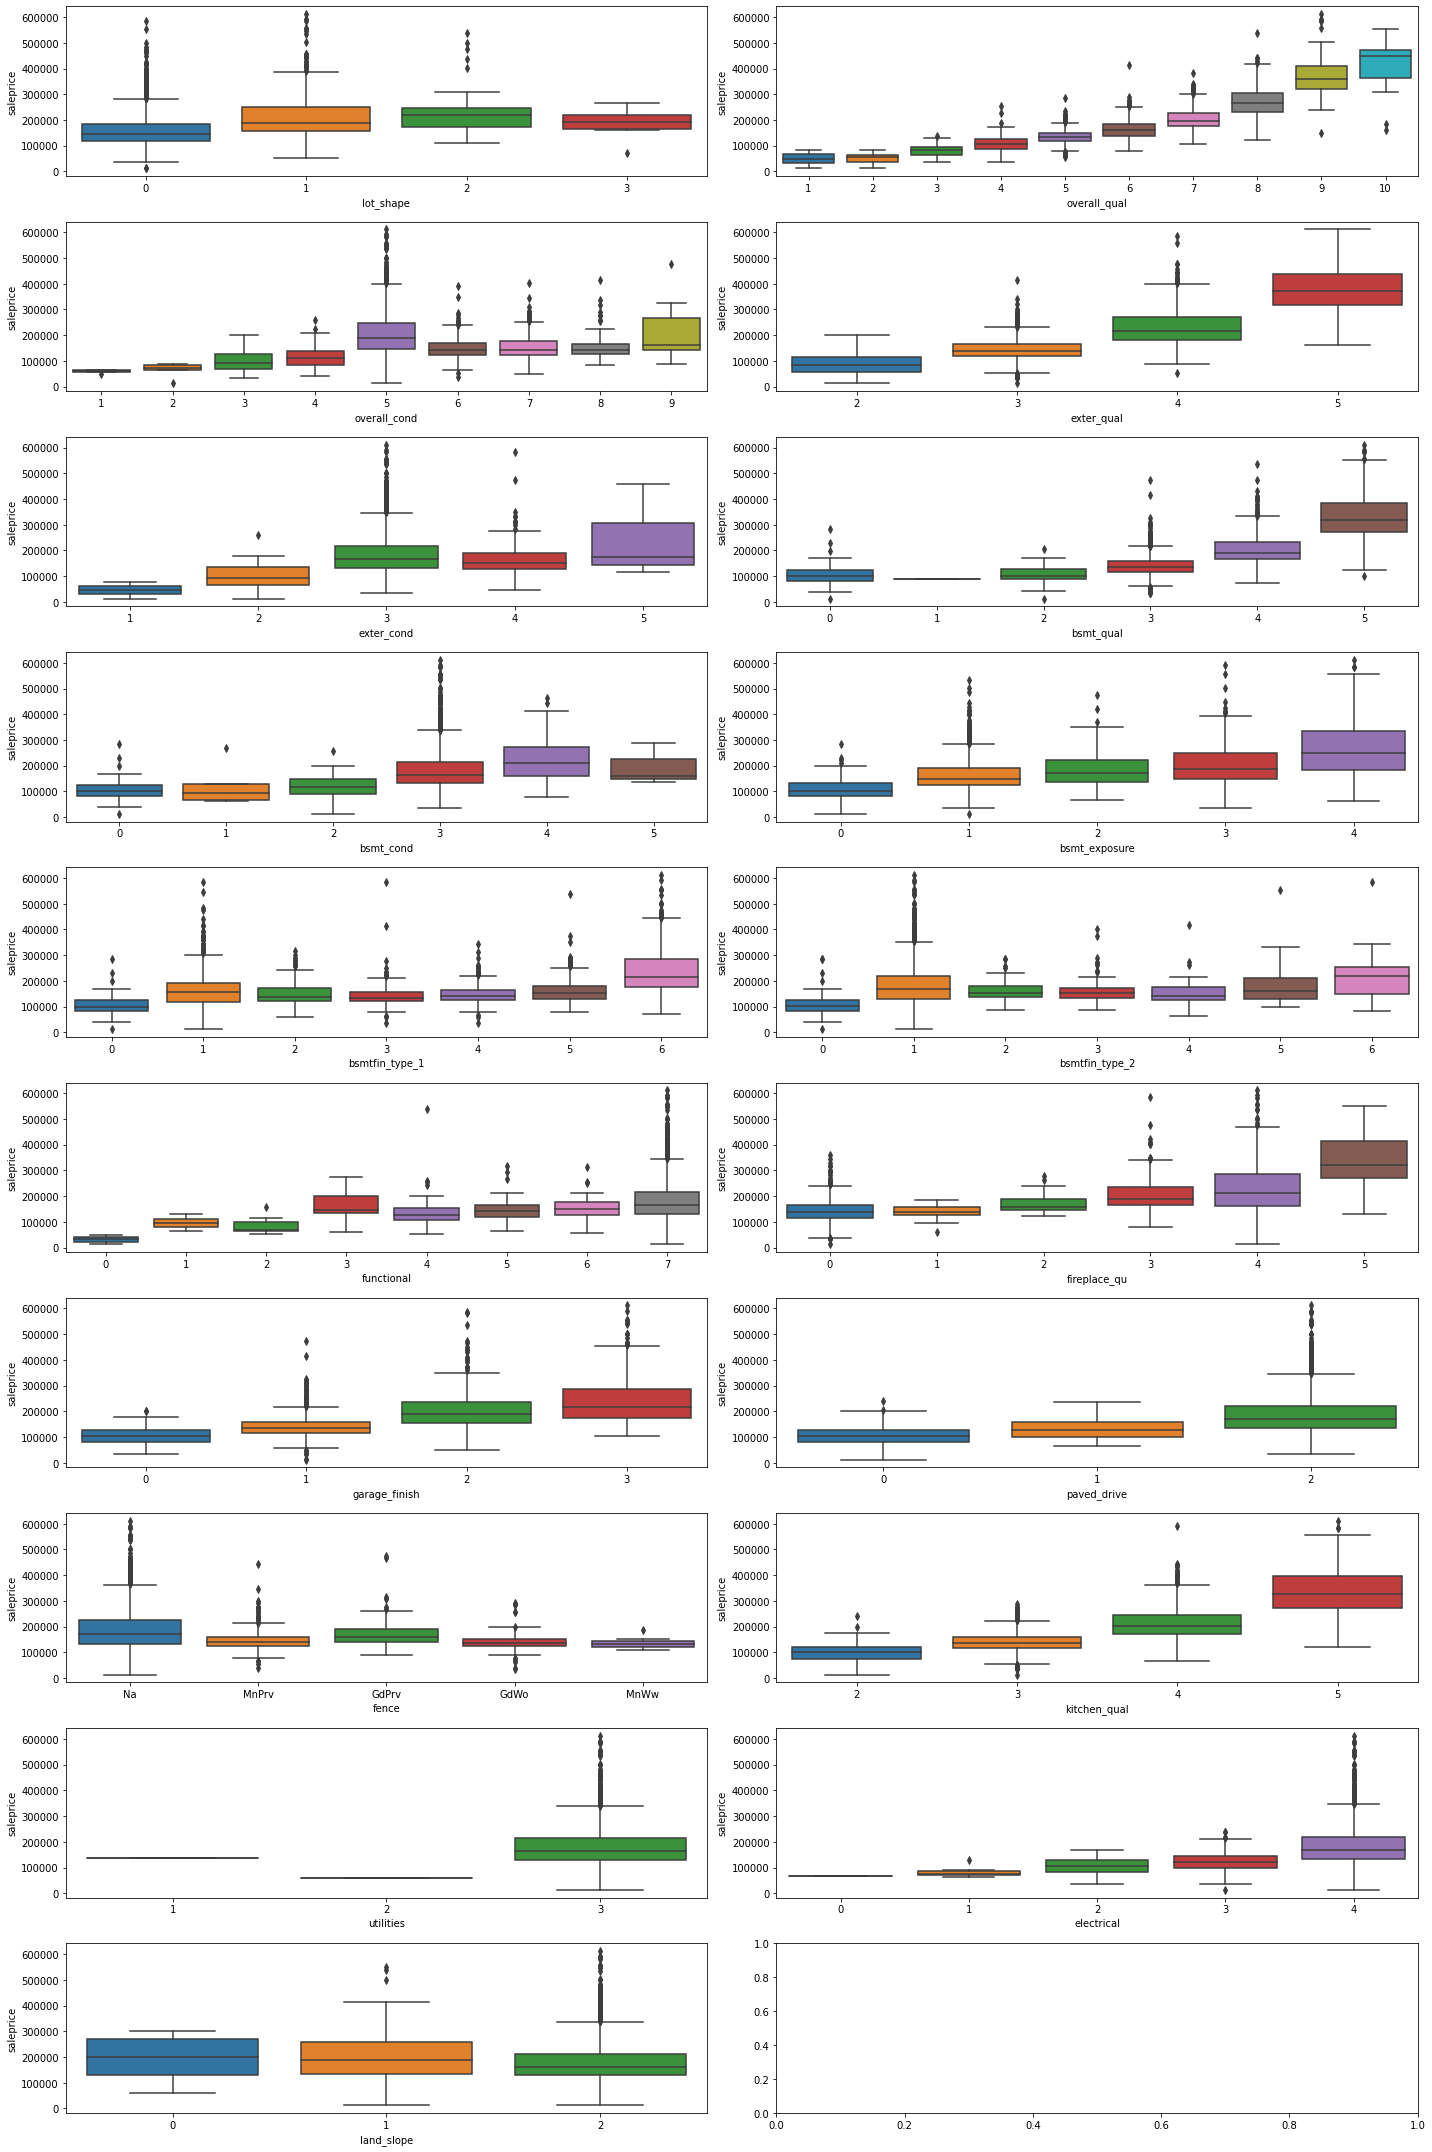

In [23]:
#Plot boxplot to see the interaction with saleprice

ord_col = train_clean[['lot_shape',
                            'overall_qual',
                            'overall_cond',
                            'exter_qual',
                            'exter_cond',
                            'bsmt_qual',
                            'bsmt_cond',
                            'bsmt_exposure',
                            'bsmtfin_type_1',
                            'bsmtfin_type_2',
                            'functional',
                            'fireplace_qu',
                            'garage_finish',
                            'paved_drive',
                            'fence',
                            'kitchen_qual',
                            'utilities',
                            'electrical',
                            'land_slope',]]
                               
saletarget = train_clean['saleprice']

fig, ax = plt.subplots(nrows=10, ncols=2, figsize =(20,30))
ax = ax.ravel() #Ravel turns the subplot shape into vector

for i, col in enumerate(ord_col[0:25]):
    sns.boxplot(x=col, y='saleprice', data=train_clean, orient = 'v', ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('saleprice')
    
plt.tight_layout()

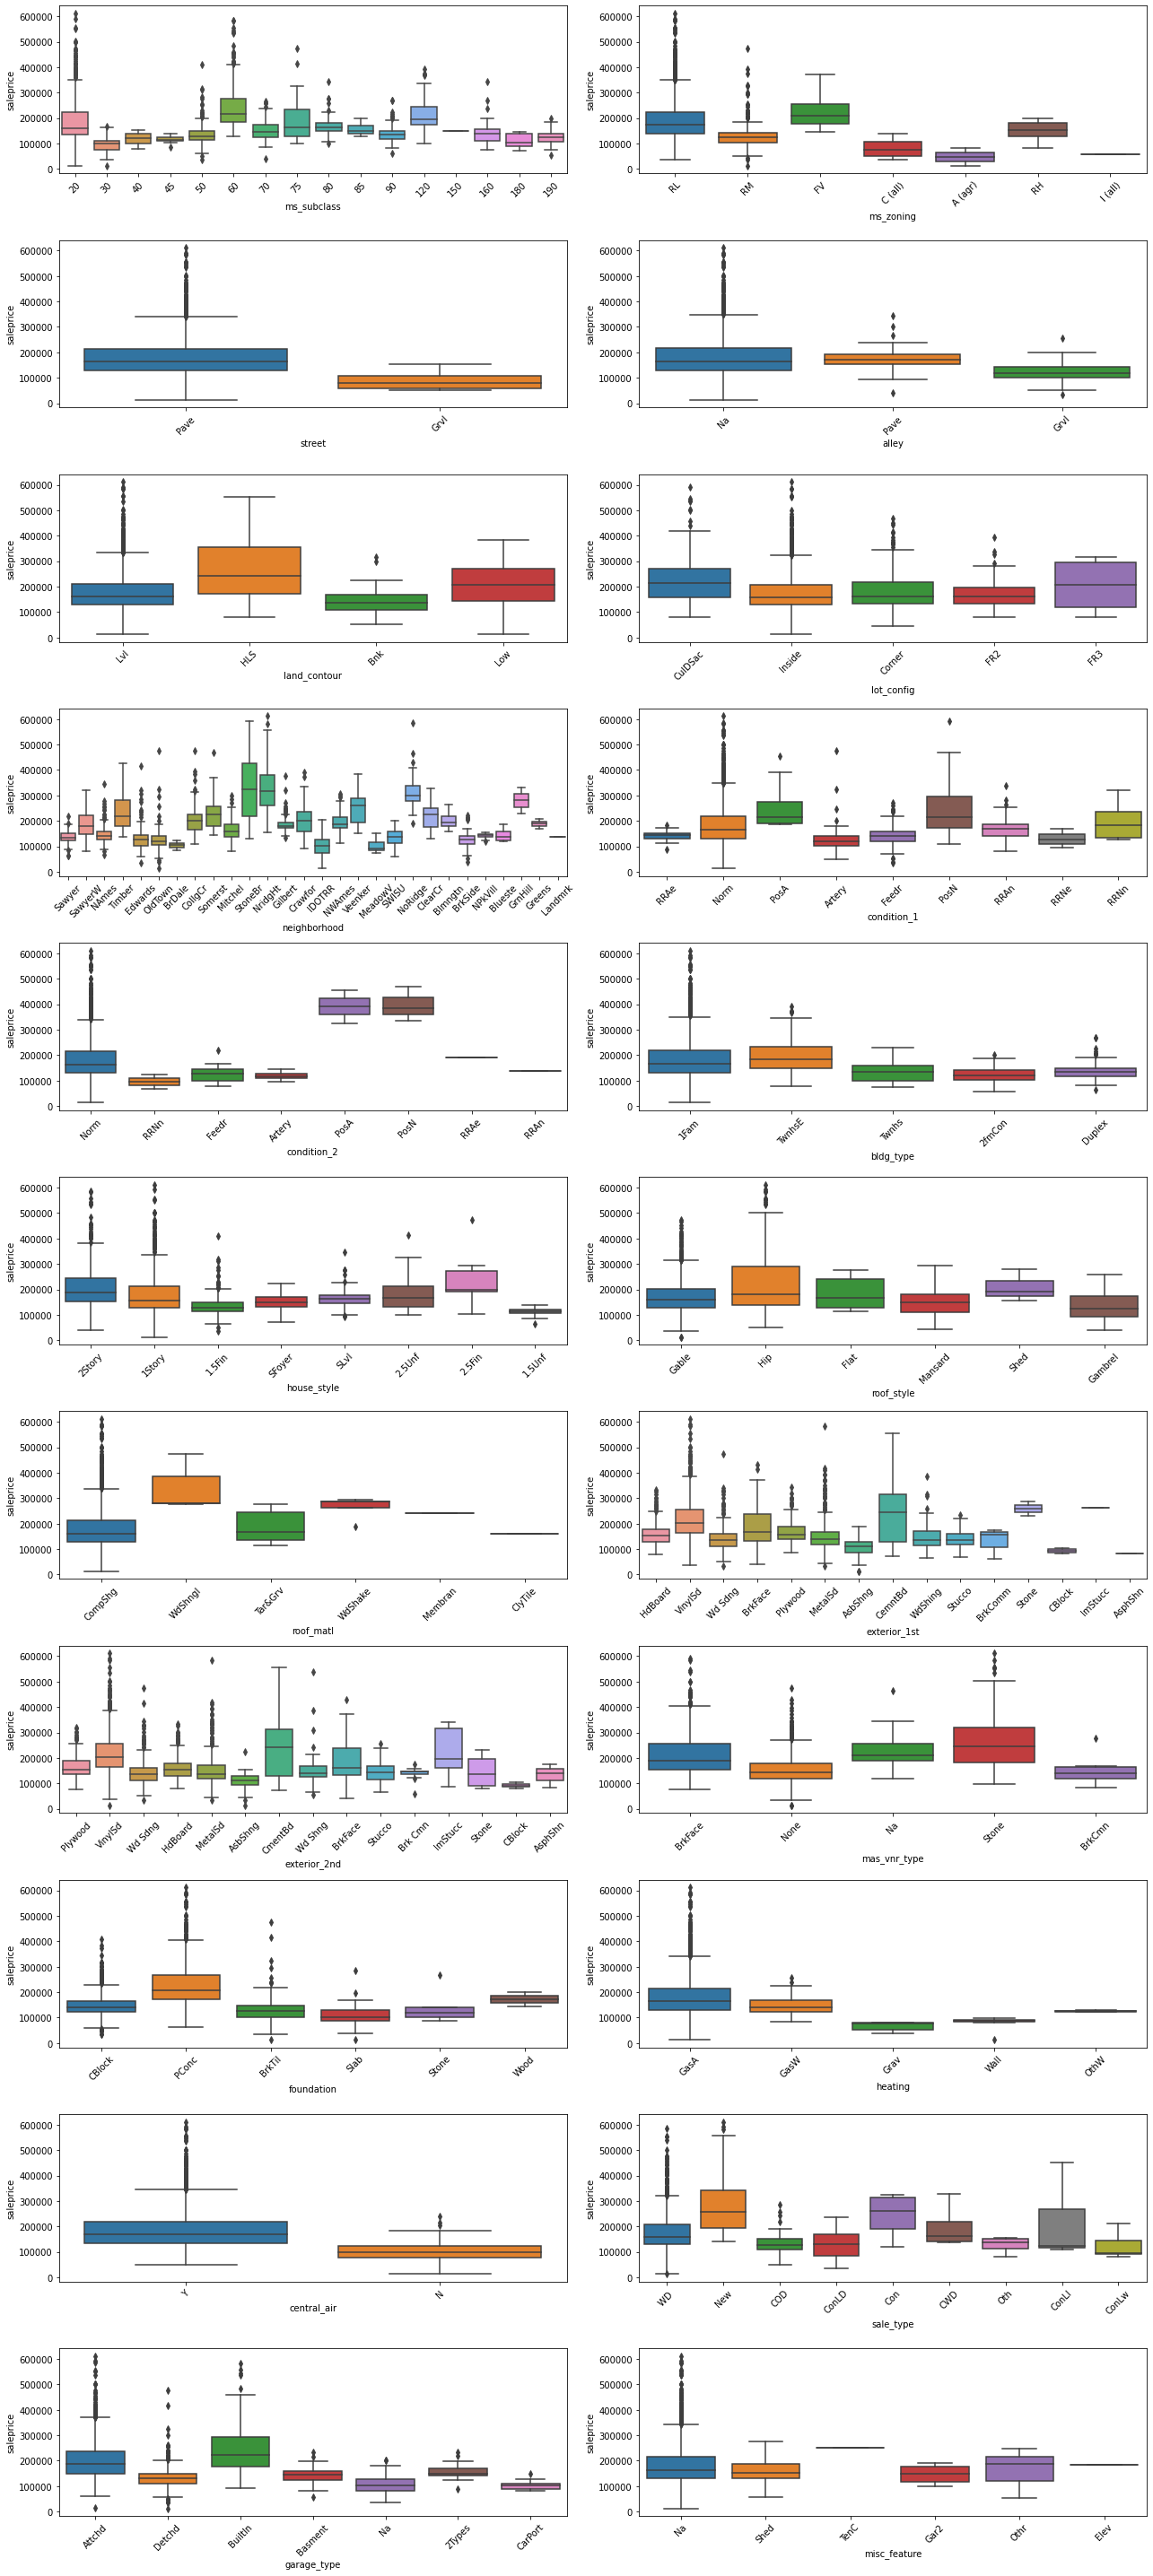

In [24]:
#Plot boxplot to see the interaction with saleprice. Boxplot works only on categorical items
nom_col = train_clean[['ms_subclass', 
                            'ms_zoning', 
                            'street', 
                            'alley', 
                            'land_contour',
                            'lot_config',
                            'neighborhood',
                            'condition_1',
                            'condition_2',
                            'bldg_type',
                            'house_style',
                            'roof_style',
                            'roof_matl',
                            'exterior_1st', 
                            'exterior_2nd', 
                            'mas_vnr_type',
                            'foundation',
                            'heating',
                            'central_air',
                            'sale_type',
                            'garage_type',
                            'misc_feature']]
                               
saletarget = train_clean['saleprice']

fig, ax = plt.subplots(nrows=11, ncols=2, figsize =(18,40))
ax = ax.ravel() #Ravel turns the subplot shape into vector


for i, col in enumerate(nom_col[0:25]):
    sns.boxplot(x=col, y='saleprice', data=train_clean, orient = 'v', ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('saleprice')
    ax[i].tick_params(axis='x', rotation=45)
  

plt.tight_layout()

In order not to dropping too many variables which may be useful for the determination of the sales price since we can use RFE to then reduce the variables further, the selection criteria for the drop of the variables depends if the boxplots clearly do not exhibit a clear pattern against sales price. E.g in misc feature, it is obvious that there are categories which had very few value counts, therefore it is unlikely to have an impact on the salesprice. Based on this criteria, the following variables are selected. 

In [25]:
#Drop columns where boxplots do not exhibit a clear pattern against saleprice
train_clean.drop(['misc_feature',
                 'ms_zoning',
                 'utilities',
                 'condition_2',
                  'pool_qc',
                 'roof_matl',
                 'alley',
                 'street',
                 'functional',
                  'heating',
                  'bsmtfin_type_1',
                 'bsmtfin_type_2'], axis=1, inplace=True)

In [26]:
#Check shape of train_clean data
train_clean.shape

(2051, 66)

### Feature Engineering

In [27]:
#Retrieve categorical data to select variables to get_dummies
categorical_cols = list(train_clean.select_dtypes(include=['object']).columns)

In [28]:
#Run code to get_dummies on categorical cols
train_dummies= pd.get_dummies(train_clean[categorical_cols])

In [29]:
#Extract the numerical data
numerical_cat= list(train_clean._get_numeric_data().columns)

In [30]:
#Combine the 2 lists to make into a list
X_train = pd.concat([train_clean[numerical_cat],train_dummies], axis=1)

In [31]:
X_train.shape

(2051, 180)

In [32]:
X_train.head()

id        pid  ms_subclass  lot_frontage  lot_area  lot_shape  land_slope  \
0  109  533352170           60       69.0552     13517          1           2   
1  544  531379050           60       43.0000     11492          1           2   
2  153  535304180           20       68.0000      7922          0           2   
3  318  916386060           60       73.0000      9802          0           2   
4  255  906425045           50       82.0000     14235          1           2   

   overall_qual  overall_cond  year_built  year_remod/add  mas_vnr_area  \
0             6             8        1976            2005           289   
1             7             5        1996            1997           132   
2             5             7        1953            2007             0   
3             5             5        2006            2007             0   
4             6             8        1900            1993             0   

   exter_qual  exter_cond  bsmt_qual  bsmt_cond  bsmt_exposure  bsmtfin_sf_1  \
0           4           3          3          3              1         533.0   
1           4           3          4          3              1         637.0   
2           3           4          3          3              1         731.0   
3           3           3          4          3              1           0.0   
4           3           3          2          4              1           0.0   

   bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  heating_qc  electrical  \
0           0.0        192.0          725.0           5           4   
1           0.0        276.0          913.0           5           4   
2           0.0        326.0         1057.0           3           4   
3           0.0        384.0          384.0           4           4   
4           0.0        676.0          676.0           3           4   

   2nd_flr_sf  low_qual_fin_sf  gr_liv_area  bsmt_full_bath  bsmt_half_bath  \
0         754                0         1479             0.0             0.0   
1        1209                0         2122             1.0             0.0   
2           0                0         1057             1.0             0.0   
3         700                0         1444             0.0             0.0   
4         614                0         1445             0.0             0.0   

   full_bath  half_bath  bedroom_abvgr  kitchen_abvgr  kitchen_qual  \
0          2          1              3              1             4   
1          2          1              4              1             4   
2          1          0              3              1             4   
3          2          1              3              1             3   
4          2          0              3              1             3   

   fireplaces  fireplace_qu  garage_finish  garage_area  paved_drive  \
0           0             0              2        475.0            2   
1           1             3              2        559.0            2   
2           0             0              1        246.0            2   
3           0             0              3        400.0            2   
4           0             0              1        484.0            0   

   wood_deck_sf  open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  \
0             0             44               0           0             0   
1             0             74               0           0             0   
2             0             52               0           0             0   
3           100              0               0           0             0   
4             0             59               0           0             0   

   pool_area  misc_val  mo_sold  yr_sold  saleprice  total_sf  total_porch_sf  \
0          0         0        3     2010     130500    2204.0              44   
1          0         0        4     2009     220000    3035.0              74   
2          0         0        1     2010     109000    2114.0              52   
3          0         0        4     2010  

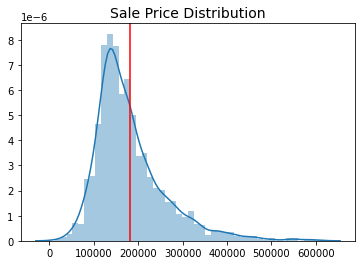

In [33]:
# Plot the distribution of the target variable, saleprice
# Red vertical line is the mean
plt.figure(figsize=(6,4))
sns.distplot(X_train['saleprice'])
plt.axvline(np.mean(X_train['saleprice']), color='red')
plt.xlabel('')
plt.title('Sale Price Distribution', size=14);

### Load and Cleaning of Test Data

In [34]:
test_clean = pd.read_csv('../datasets/test_clean1.csv')

In [35]:
#Create an additional column to account for total square foot which is missing in the data provided
test_clean["total_sf"] = test_clean["gr_liv_area"] + test_clean['total_bsmt_sf']

In [36]:
#Create an additional column to account for the porch spaces
test_clean["total_porch_sf"] = test_clean["3ssn_porch"] + test_clean["enclosed_porch"] + test_clean["open_porch_sf"] + test_clean["screen_porch"] + test_clean["wood_deck_sf"]

In [37]:
#Create an additional column to account for the bathrooms
test_clean["total_bath"] = test_clean["full_bath"] + 0.5*test_clean["half_bath"] + test_clean["bsmt_full_bath"] + 0.5*test_clean["bsmt_half_bath"]

In [38]:
test_clean.drop(['garage_cars', 
                 'totrms_abvgrd',
                 '1st_flr_sf',
                 'garage_yr_blt',
                 'garage_cond',
                 'garage_qual',
                 'misc_feature',
                 'ms_zoning',
                 'utilities',
                 'condition_2',
                  'pool_qc',
                 'roof_matl',
                 'alley',
                 'street',
                 'functional',
                  'heating',
                'bsmtfin_type_1',
                 'bsmtfin_type_2'
                ], axis=1, inplace=True)

In [39]:
#Rerieve categorical data to select variables to get_dummies
categorical_cols = list(test_clean.select_dtypes(include=['object']).columns)

In [40]:
#Run code to get_dummies on categorical cols
test_dummies = pd.get_dummies(test_clean[categorical_cols])

In [41]:
#Categorise the numerical data
numerical_cat = list(test_clean._get_numeric_data().columns)

In [42]:
#Concatenate both sets of data
testset = pd.concat([test_clean[numerical_cat], test_dummies], axis=1)

In [43]:
#Set the predictors as the common columns between the 2 sets of data
predictors = set(X_train.columns).intersection(set(testset.columns))

## Modelling

### Baseline Model

In [44]:
#Sets target variable 'saleprice' as y
y = X_train['saleprice']
#Sets feature variables as X
X = X_train[predictors]



In [45]:
#Train test split (Random state is set for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X,y)

#Standardize data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [46]:
#Create predictions based on mean price
base_pred = pd.DataFrame(np.full(len(y_test),y.mean()));

In [47]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_test,base_pred))

80075.71510060561

### Linear Regression

In [48]:
#instantiate Model
model = LinearRegression()

In [49]:
# Check CVS
cross_val_score(model, X_train, y_train, cv=5).mean()

0.8402046704809607

In [50]:
# Fit model to training data
model.fit(X_train, y_train);

In [51]:
# Generate R2 score for training data
model.score(X_train, y_train)

0.9109822421996423

In [52]:
# Generate R2 score for test data
model.score(X_test, y_test)

0.8110477426870465

In [53]:
# Generation predictions from model, train data, will still be in log form
y_train_pred = model.predict(X_train)


In [54]:
# Calculate MSE for train data
mse = metrics.mean_squared_error(y_train, y_train_pred)
print(f'MSE: {mse}')

# RMSE for train data
print(f'RMSE: {np.sqrt(mse)}')

MSE: 554974729.718345
RMSE: 23557.901640815657


In [55]:
# Generation predictions from model, test data, will still be in log form
y_test_pred= model.predict(X_test)



In [56]:
# Calculate MSE for test data
mse = metrics.mean_squared_error(y_test, y_test_pred)
print(f'MSE: {mse}')

# RMSE for test data
print(f'RMSE: {np.sqrt(mse)}')

MSE: 1211584286.3634982
RMSE: 34807.81932789669


The RMSE for the test data is much higher than that of the train data which indicates that the model is an overfit

### Ridge Regression

In [57]:
#Specify desired values to try for each hyperparameter
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
                 
grid_rg = GridSearchCV(Ridge(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid_rg.fit(X_train_sc, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8485749731127775
Best Params:  {'alpha': 1000}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.2s finished


In [58]:
pred = grid_rg.best_estimator_.predict(X_test_sc)
np.sqrt(metrics.mean_squared_error(y_test,pred))

32887.6505015773

### Lasso Regression

In [59]:
# feature extraction
rfe = RFE(LassoCV(),n_features_to_select=30)
rfe_fit = rfe.fit(X_train_sc,y_train)
# print("Num Features: %d" % rfe_fit.n_features_)
# print("Selected Features: %s" % rfe_fit.support_)
# print("Feature Ranking: %s" % rfe_fit.ranking_)
dfsupport = pd.DataFrame(rfe_fit.support_)
dfranking = pd.DataFrame(rfe_fit.ranking_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfsupport,dfranking],axis=1)
# naming the dataframe columns
featureScores.columns = ['Feature','Selection','Rank']


In [60]:
top_30 = featureScores.loc[featureScores['Selection']==True]
best_feature = [i for i in top_30['Feature']]

In [61]:
best_feature

['exter_qual',
 'garage_area',
 'overall_qual',
 'screen_porch',
 'exterior_1st_BrkFace',
 'neighborhood_StoneBr',
 'fireplace_qu',
 'mas_vnr_area',
 'mas_vnr_type_BrkFace',
 'roof_style_Hip',
 'roof_style_Mansard',
 'bsmtfin_sf_1',
 'gr_liv_area',
 'neighborhood_NoRidge',
 'total_bath',
 'bsmt_exposure',
 'neighborhood_NridgHt',
 'neighborhood_Edwards',
 'exterior_1st_Stucco',
 'garage_type_Na',
 'overall_cond',
 'pool_area',
 'kitchen_qual',
 'ms_subclass',
 'sale_type_New',
 'lot_area',
 'land_contour_HLS',
 'year_built',
 'bsmt_qual',
 'bsmt_cond']

In [62]:
X = X[best_feature]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.05)

In [64]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [65]:
#Specify desired values to try for each hyperparameter
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha, max_iter = [5000])

grid_ls = GridSearchCV(Lasso(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid_ls.fit(X_train_sc, y_train)
another_model = grid_ls.best_estimator_

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print ('Number of best coef: ', np.sum(grid_ls.best_estimator_.coef_ !=0))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.8416432591970086
Best Params:  {'alpha': 100, 'max_iter': 5000}
Number of best coef:  30


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


In [66]:
# RMSE
pred = grid_ls.best_estimator_.predict(X_test_sc)
np.sqrt(metrics.mean_squared_error(y_test,pred))

25820.5517014802

### ElasticNet

In [67]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0,.3,.5,.7,1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio, max_iter=[10000])

param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid_en = GridSearchCV(ElasticNet(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid_en.fit(X_train_sc, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print ('Number of best coef: ', np.sum(grid_en.best_estimator_.coef_ !=0))

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8508306459876562
Best Params:  {'alpha': 1, 'l1_ratio': 0.7}
Number of best coef:  30


[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.1s finished


In [68]:
pred = grid_en.best_estimator_.predict(X_test_sc)
np.sqrt(metrics.mean_squared_error(y_test,pred))

27626.394079983907

In [69]:
#creates table of all feature variables and their model coefficients
coef_table = pd.DataFrame(grid_ls.best_estimator_.coef_, index=X_train.columns, columns=['Coefficients'])
#creates column with coefficient magnitudes
coef_table['Magnitude']=abs(coef_table['Coefficients'])
#sorts features by coefficient magnitude (i.e.; predictive power) and shows top 25 most influential features
coef_table.sort_values('Magnitude',ascending=False).head(25)['Coefficients']

gr_liv_area             18992.031591
overall_qual            14483.313814
neighborhood_NridgHt     9723.525866
ms_subclass             -8452.101986
total_bath               7159.797123
exter_qual               6698.892312
neighborhood_StoneBr     6511.624728
bsmt_exposure            6502.376917
garage_area              6352.219031
kitchen_qual             6058.932367
year_built               5640.824572
neighborhood_NoRidge     5524.473259
overall_cond             5499.807095
bsmt_qual                5210.720426
fireplace_qu             5051.762576
screen_porch             4086.247275
mas_vnr_area             4052.280622
bsmtfin_sf_1             4002.849916
sale_type_New            3755.487324
lot_area                 3568.100636
exterior_1st_BrkFace     3227.847568
land_contour_HLS         2832.698440
bsmt_cond               -2760.631967
neighborhood_Edwards    -2758.561073
roof_style_Hip           2728.224915
Name: Coefficients, dtype: float64

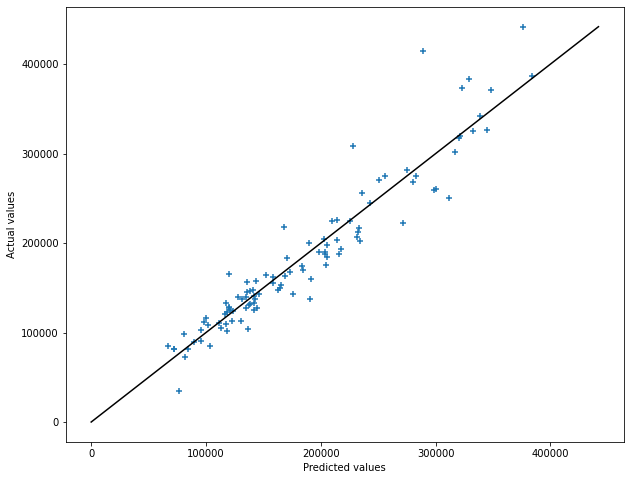

In [70]:
#Generates a list of the model's (lasso regression) predictions for the test 
pred = grid_ls.best_estimator_.predict(X_test_sc)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter((pred),y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

From the graph above, it can be seen that lasso regression is a good predictor for the saleprice for values approximately between 100,000 to 250,000 but further from the line plot for higher values. This also is in line with the distribution of the sales price plotted above which indicated the sale price is not a normal distribution. 

In [71]:
#Initializes model for whole training set
ls_full_trainset = grid_ls.best_estimator_
#Applies StandardScaler normalization to whole training set
X_sc = ss.fit_transform(X)

#Re-fits the model
ls_full_trainset.fit(X_sc,y)
#Scores the model (training score only, of course)
ls_full_trainset.score(X_sc,y)

0.8780553532165011

### Generate model prediction for testset

In [72]:
data = testset[predictors]

In [73]:
X = data[best_feature]

In [74]:
#scale test set
testset_sc= ss.transform(X)

In [75]:
#Generate model prediction for testset
predictions = ls_full_trainset.predict(testset_sc)

In [76]:
#Create submission csv in proper format
testset['saleprice'] = predictions
# testfile = pd.read_csv('../datasets/test_clean1.csv')
# testset['id'] = testfile['id']
submission = testset[['id','saleprice']]
submission.to_csv('../datasets/kaggle_submission.csv',index=False)

#View submission
submission.head()

id      saleprice
0  2658  118732.223914
1  2718  147595.297929
2  2414  235339.857740
3  1989  112626.761903
4   625  184647.852608

## Conclusion and Recommendations

Based on the exploratory data analysis, it can be observed that many variables are found to be collinear and pertains to a certain feature in the house. However, sellers and buyers must have some tangible features that can be easily quantifable upon purchasing / selling a place. From the top features, we can see overall quality and total square feet, total baths are some of the top features which have high correlation with the sale price. At the same time, RFE can be deployed to further to narrow down the variables to meet the objective of 30 variables.

Therefore, homeowners seeking to increase their house value can improve its overall quality, expand the above ground living area etc.

At the same time, there are also other variables which are negative and homebuyers seeking a home for investment should take these into considerations. 

In conclusion, the lasso model has the best scoring when it comes to predicting sale prices of home. 

